## Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

## Load the Main Dataset

In [3]:
# # importing the "tarfile" module
# import tarfile

# # open dataset train
# file = tarfile.open('drive/MyDrive/dataset/train.tar.gz')  

# # extracting file
# file.extractall('drive/MyDrive/dataset')
# file.close()

In [4]:
# # open dataset test
# import tarfile
# file = tarfile.open('drive/MyDrive/dataset/dev.tar.gz')  

# # extracting file
# file.extractall('drive/MyDrive/dataset')
# file.close()

In [5]:
!pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from natsort import natsorted
#load paths for train data
paths_train = []
labels_train = []
for dirname, _, filenames in os.walk('drive/MyDrive/dataset/train_splits'):
  sorted_fl = natsorted(filenames)
  for filename in sorted_fl:
    paths_train.append(os.path.join(dirname, filename))

df_train = pd.read_csv("drive/MyDrive/dataset/texts/train_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
labels_train = df_train['Emotion']

#load paths for train data
paths_test = []
labels_test = []
flnames_test = []
for dirname, _, filenames in os.walk('drive/MyDrive/dataset/output_repeated_splits_test'):
  sorted_fl = natsorted(filenames)
  for filename in sorted_fl:
    if filename.find('._') == 0:
      continue
    elif filename.find('final') == 0:
      continue
    else:
      paths_test.append(os.path.join(dirname, filename))
      flnames_test.append(filename)

df_test = pd.read_csv("drive/MyDrive/dataset/texts/test_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
labels_test = df_test['Emotion']

In [7]:
print("train-data: ",len(paths_train))
print("label-train-data: ",len(labels_train))

train-data:  9989
label-train-data:  9989


In [8]:
paths_train[-5:]

['drive/MyDrive/dataset/train_splits/dia1038_utt13.mp4',
 'drive/MyDrive/dataset/train_splits/dia1038_utt14.mp4',
 'drive/MyDrive/dataset/train_splits/dia1038_utt15.mp4',
 'drive/MyDrive/dataset/train_splits/dia1038_utt16.mp4',
 'drive/MyDrive/dataset/train_splits/dia1038_utt17.mp4']

In [9]:
print("test-data: ",len(paths_test))
print("label-test-data: ",len(labels_test))

test-data:  2615
label-test-data:  2610


##Preprocess Dataset

### Preprocess Train Data

In [10]:
## Create a dataframe for train data
df_tr_temp = pd.DataFrame()
df_tr_temp['speech'] = paths_train
df_tr_temp['label'] = labels_train
df_tr_temp.head()

,speech,label
0,drive/MyDrive/dataset/train_splits/dia0_utt0.mp4,neutral
1,drive/MyDrive/dataset/train_splits/dia0_utt1.mp4,neutral
2,drive/MyDrive/dataset/train_splits/dia0_utt2.mp4,neutral
3,drive/MyDrive/dataset/train_splits/dia0_utt3.mp4,neutral
4,drive/MyDrive/dataset/train_splits/dia0_utt4.mp4,surprise


In [11]:
df_tr_temp['label'].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: label, dtype: int64

In [12]:
df_tr_temp = df_tr_temp[df_tr_temp['label'] != 'fear']
df_tr_temp = df_tr_temp[df_tr_temp['label'] != 'disgust']

df_tr_temp['label'].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
Name: label, dtype: int64

In [13]:
from sklearn.utils import resample,shuffle

df_emo_1 = df_tr_temp[df_tr_temp['label'] == 'neutral']
df_1_upsampled = resample(df_emo_1,random_state=42,n_samples=683,replace=True)

df_emo_2 = df_tr_temp[df_tr_temp['label'] == 'joy']
df_2_upsampled = resample(df_emo_2,random_state=0,n_samples=683,replace=True)

df_emo_3 = df_tr_temp[df_tr_temp['label'] == 'surprise']
df_3_upsampled = resample(df_emo_3,random_state=42,n_samples=683,replace=True)

df_emo_4 = df_tr_temp[df_tr_temp['label'] == 'anger']
df_4_upsampled = resample(df_emo_4,random_state=42,n_samples=683,replace=True)

df_emo_5 = df_tr_temp[df_tr_temp['label'] == 'sadness']
# df_emo_6 = df_tr_temp[df_tr_temp['label'] == 'fear']
# df_emo_7 = df_tr_temp[df_tr_temp['label'] == 'disgust']

# df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5,df_emo_6,df_emo_7])
df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5])
# df_tr_path = pd.concat([df_1_upsampled,df_2_upsampled,df_4_upsampled,df_emo_5])
                        
df_tr_path['label'].value_counts()

neutral     683
joy         683
surprise    683
anger       683
sadness     683
Name: label, dtype: int64

In [14]:
df_tr_path = df_tr_path.sample(frac=1,random_state=42).reset_index()

###Preprocess Test Data

In [15]:
def non_match_elements(list_a, list_b):
    non_match = []
    for i in list_a:
        if i not in list_b:
            non_match.append(i)
    return non_match

In [16]:
list_flname = []
for a in range(len(df_test)):
  flname = "dia" + str(df_test['Dialogue_ID'][a]) + "_utt" + str(df_test['Utterance_ID'][a]) + ".mp4"
  list_flname.append(flname)

print(list_flname[:5])

['dia0_utt0.mp4', 'dia0_utt1.mp4', 'dia0_utt2.mp4', 'dia1_utt0.mp4', 'dia1_utt1.mp4']


In [17]:
print(flnames_test[:5])

['dia0_utt0.mp4', 'dia0_utt1.mp4', 'dia0_utt2.mp4', 'dia1_utt0.mp4', 'dia1_utt1.mp4']


In [18]:
non_matches = non_match_elements(flnames_test,list_flname)
print(non_matches)

for b in range(len(non_matches)):
  fl_index = flnames_test.index(non_matches[b])
  flnames_test.pop(fl_index)
  paths_test.pop(fl_index)

['dia93_utt5.mp4', 'dia93_utt6.mp4', 'dia93_utt7.mp4', 'dia108_utt1.mp4', 'dia108_utt2.mp4']


In [19]:
print(paths_test[799])

drive/MyDrive/dataset/output_repeated_splits_test/dia93_utt8.mp4


In [20]:
df_test_temp = pd.DataFrame()
df_test_temp['speech'] = paths_test
df_test_temp['label'] = labels_test

In [21]:
df_test_temp = df_test_temp[df_test_temp['label'] != 'fear']
df_test_temp = df_test_temp[df_test_temp['label'] != 'disgust']

df_test_temp['label'].value_counts()

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
Name: label, dtype: int64

In [22]:
df_test_path = df_test_temp

## Cleaned Dataset Labels

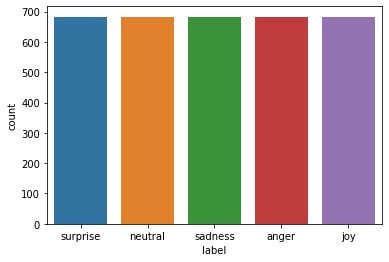

In [23]:
sns.countplot(df_tr_path['label'])

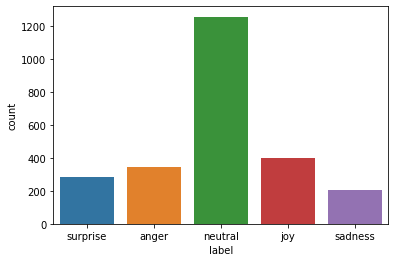

In [24]:
sns.countplot(df_test_path['label'])

## Show Sample Train Data

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
# emotion = 'fear'
# path = np.array(df_tr_path['speech'][df_tr_path['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'anger'
# path = np.array(df_tr_path['speech'][df_tr_path['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'disgust'
# path = np.array(df_tr_path['speech'][df_tr_path['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'neutral'
# path = np.array(df_tr_path['speech'][df_tr_path['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'sadness'
# path = np.array(df['speech'][df['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'joy'
# path = np.array(df['speech'][df['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
# emotion = 'surprise'
# path = np.array(df['speech'][df['label']==emotion])[0]
# data, sampling_rate = librosa.load(path)
# waveplot(data, sampling_rate, emotion)
# spectogram(data, sampling_rate, emotion)
# Audio(path)

## Feature Extraction

###Define extract_mfcc function

In [25]:
n_features = 128

In [26]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=120)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_features)
    mfccScaled = np.mean(mfcc.T,axis=0)
    return mfccScaled

### Remove error dataset

In [ ]:
# print(df_tr_path.loc[df_tr_path['speech'] == 'drive/MyDrive/dataset/train_splits/dia902_utt0.mp4'])
# print(df_tr_path.loc[df_tr_path['speech'] == 'drive/MyDrive/dataset/train_splits/dia147_utt6.mp4'])

In [ ]:
# df_temp_tr = df_tr_path

In [ ]:
# df_temp_tr = df_temp_tr.drop(df_temp_tr.index[df_temp_tr['speech'] == 'drive/MyDrive/dataset/train_splits/dia147_utt6.mp4'], inplace = False)
# df_temp_tr = df_temp_tr.drop(df_temp_tr.index[df_temp_tr['speech'] == 'drive/MyDrive/dataset/train_splits/dia9_utt7.mp4'], inplace = False)
# df_temp_tr = df_temp_tr.drop(df_temp_tr.index[df_temp_tr['speech'] == 'drive/MyDrive/dataset/train_splits/dia902_utt0.mp4'], inplace = False)

In [ ]:
# df_temp_tr[1164:1166]

In [ ]:
# df_tr_path = df_temp_tr

###Extract audio train data to mfcc

In [27]:
# X_mfcc = df_tr_path['speech'].apply(lambda x: extract_mfcc(x))

In [28]:
X_mfcc = np.load('./drive/MyDrive/Thesis_code/features/X_train_5emo_bal.npy',allow_pickle=True)

In [29]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(3415, 128)

In [30]:
## input split
X = np.expand_dims(X, -1)
X.shape

(3415, 128, 1)

In [31]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df_tr_path[['label']])

In [32]:
y = y.toarray()

In [33]:
y.shape

(3415, 5)

###Extract test audio data to mfcc

In [34]:
# X_test_mfcc = df_test_path['speech'].apply(lambda x: extract_mfcc(x))
X_test_mfcc = np.load('./drive/MyDrive/Thesis_code/features/X_test_5emo_bal.npy',allow_pickle=True)
X_test = [x for x in X_test_mfcc]
X_test = np.array(X_test)
X_test.shape

X_test = np.expand_dims(X_test, -1)
X_test.shape

(2492, 128, 1)

In [35]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_test = enc.fit_transform(df_test_path[['label']])
y_test = y_test.toarray()
y_test.shape

(2492, 5)

## Define the BiLSTM Models

In [44]:
#Libraries
from tensorflow import keras
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional, AveragePooling2D, AveragePooling1D, MaxPool1D, Conv1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.optimizers import Adam
from keras.models import Model, load_model, Sequential
import keras.backend as K
reg = keras.regularizers.l2(l2=0.0001)
opt = keras.optimizers.Adam(lr=0.0001)

###Define Proposed Model

In [92]:
inputs = Input(shape=(n_features, 1), dtype='float32')
masked = Masking(mask_value =0)(inputs)
lstm = Bidirectional(LSTM(256, activation='tanh',return_sequences = True, dropout=0.4))(masked)
lstm = Bidirectional(LSTM(128, activation='tanh',return_sequences = False, dropout=0.3))(lstm)
# lstm = Bidirectional(LSTM(128, activation='tanh',return_sequences = True, dropout=0.4))(lstm)
# lstm = Bidirectional(LSTM(256, activation='tanh',return_sequences = True, dropout=0.3))(masked)
# lstm = Bidirectional(LSTM(128, activation='tanh',return_sequences = False, dropout=0.3))(lstm)
# l_flat = Flatten()(lstm)
# l_dense_1 = Dense(64,activation='relu',kernel_regularizer=reg,dropout=0.2)(l_flat)
l_dense_1 = Dense(64,activation='relu',kernel_regularizer=reg)(lstm)
l_do1 = Dropout(0.2)(l_dense_1)
l_dense_2 = Dense(32,activation='relu',kernel_regularizer=reg)(l_do1)
output = Dense(units=5,activation='softmax',kernel_regularizer=reg)(l_dense_2)

model = Model(inputs, output)
# opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 masking_3 (Masking)         (None, 128, 1)            0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 128, 512)         528384    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0   

###Load Proposed Model

In [93]:
# #Load model

model_1 = keras.models.load_model('drive/MyDrive/Thesis_code/model/BiLSTM_SER-5emo-bal')
model_1.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 masking_16 (Masking)        (None, 128, 1)            0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 128, 512)         528384    
 onal)                                                           
                                                                 
 bidirectional_40 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 64)                16448     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0  

###Define Baseline Models

In [75]:
# inputs_bs1 = Input(shape=(n_features, 1), dtype='float32')
# masked_bs1 = Masking(mask_value =0)(inputs_bs1)
# lstm_bs1 = Bidirectional(LSTM(300, activation='tanh', return_sequences = True, dropout=0.4))(masked_bs1)
# lstm_bs1 = Bidirectional(LSTM(300, activation='tanh', return_sequences = False, dropout=0.4), name="utter")(lstm_bs1)
# output_bs1 = Dense(5,activation='softmax')(lstm_bs1)

# baseline_1 = Model(inputs_bs1, output_bs1)
# baseline_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# baseline_1.summary()

baseline_1 = Sequential()
baseline_1.add(Input(shape=(n_features, 1), dtype='float32'))
baseline_1.add(Bidirectional(LSTM(300, return_sequences=True, activation='tanh', dropout=0.4)))
baseline_1.add(Bidirectional(LSTM(300, return_sequences=False, activation='tanh', dropout=0.4)))
baseline_1.add(Dense(5,activation='softmax'))

baseline_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
baseline_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 128, 600)         724800    
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 600)              2162400   
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 5)                 3005      
                                                                 
Total params: 2,890,205
Trainable params: 2,890,205
Non-trainable params: 0
_________________________________________________________________


In [109]:
baseline_2 = Sequential()
baseline_2.add(Input(shape=(n_features, 1),dtype='float32'))
baseline_2.add(Bidirectional(LSTM(512, return_sequences=True)))
baseline_2.add(Bidirectional(LSTM(256, return_sequences=False)))
baseline_2.add(Dense(512))
baseline_2.add(Activation('relu'))
baseline_2.add(Dense(5))
baseline_2.add(Activation('softmax'))

baseline_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
baseline_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 128, 1024)        2105344   
 onal)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 512)              2623488   
 onal)                                                           
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 activation_18 (Activation)  (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 5)                 2565      
                                                                 
 activation_19 (Activation)  (None, 5)               

##Training Model and Plot Training Result

###Train baseline models

In [78]:
history_bs1 = baseline_1.fit(X, y, validation_split=0.15, epochs=30, batch_size=32)

Epoch 1/30
91/91 [==============================] - 5s 49ms/step - loss: 1.6000 - accuracy: 0.2340 - val_loss: 1.5979 - val_accuracy: 0.2066
Epoch 2/30
91/91 [==============================] - 4s 49ms/step - loss: 1.5982 - accuracy: 0.2429 - val_loss: 1.5965 - val_accuracy: 0.2417
Epoch 3/30
91/91 [==============================] - 5s 49ms/step - loss: 1.5947 - accuracy: 0.2312 - val_loss: 1.5980 - val_accuracy: 0.2495
Epoch 4/30
91/91 [==============================] - 5s 50ms/step - loss: 1.5907 - accuracy: 0.2498 - val_loss: 1.5946 - val_accuracy: 0.2534
Epoch 5/30
91/91 [==============================] - 5s 50ms/step - loss: 1.5869 - accuracy: 0.2488 - val_loss: 1.6008 - val_accuracy: 0.2476
Epoch 6/30
91/91 [==============================] - 5s 51ms/step - loss: 1.5805 - accuracy: 0.2567 - val_loss: 1.5862 - val_accuracy: 0.2671
Epoch 7/30
91/91 [==============================] - 5s 50ms/step - loss: 1.5827 - accuracy: 0.2643 - val_loss: 1.6050 - val_accuracy: 0.2378
Epoch 8/30
91

In [110]:
history_bs2 = baseline_2.fit(X, y, validation_split=0.15, epochs=30, batch_size=32)

Epoch 1/30
91/91 [==============================] - 14s 84ms/step - loss: 1.6039 - accuracy: 0.2371 - val_loss: 1.6146 - val_accuracy: 0.2222
Epoch 2/30
91/91 [==============================] - 6s 68ms/step - loss: 1.5816 - accuracy: 0.2574 - val_loss: 1.6218 - val_accuracy: 0.2125
Epoch 3/30
91/91 [==============================] - 6s 69ms/step - loss: 1.5743 - accuracy: 0.2619 - val_loss: 1.6095 - val_accuracy: 0.2320
Epoch 4/30
91/91 [==============================] - 6s 70ms/step - loss: 1.5686 - accuracy: 0.2667 - val_loss: 1.5981 - val_accuracy: 0.2437
Epoch 5/30
91/91 [==============================] - 6s 70ms/step - loss: 1.5623 - accuracy: 0.2757 - val_loss: 1.6067 - val_accuracy: 0.2417
Epoch 6/30
91/91 [==============================] - 6s 71ms/step - loss: 1.5602 - accuracy: 0.2808 - val_loss: 1.5994 - val_accuracy: 0.2242
Epoch 7/30
91/91 [==============================] - 6s 71ms/step - loss: 1.5506 - accuracy: 0.2895 - val_loss: 1.5968 - val_accuracy: 0.2398
Epoch 8/30
9

###Train proposed model

In [ ]:
# Train the model
num_epochs=30
history = model.fit(X, y, validation_split=0.15, epochs=num_epochs, batch_size=32)

Epoch 1/30
91/91 [==============================] - 25s 96ms/step - loss: 1.6264 - accuracy: 0.2071 - val_loss: 1.6246 - val_accuracy: 0.2105
Epoch 2/30
91/91 [==============================] - 4s 42ms/step - loss: 1.6220 - accuracy: 0.2309 - val_loss: 1.6234 - val_accuracy: 0.2047
Epoch 3/30
91/91 [==============================] - 4s 41ms/step - loss: 1.6203 - accuracy: 0.2185 - val_loss: 1.6238 - val_accuracy: 0.2281
Epoch 4/30
91/91 [==============================] - 4s 41ms/step - loss: 1.6158 - accuracy: 0.2326 - val_loss: 1.6218 - val_accuracy: 0.2047
Epoch 5/30
91/91 [==============================] - 4s 41ms/step - loss: 1.6165 - accuracy: 0.2219 - val_loss: 1.6173 - val_accuracy: 0.2281
Epoch 6/30
91/91 [==============================] - 4s 42ms/step - loss: 1.6152 - accuracy: 0.2298 - val_loss: 1.6195 - val_accuracy: 0.2183
Epoch 7/30
91/91 [==============================] - 4s 41ms/step - loss: 1.6105 - accuracy: 0.2354 - val_loss: 1.6135 - val_accuracy: 0.2417
Epoch 8/30
9

###Show Training & Validation Accuracy also Loss

In [ ]:
# epochs = list(range(num_epochs))
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, label='train accuracy')
# plt.plot(epochs, val_acc, label='val accuracy')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.plot(epochs, loss, label='train loss')
# plt.plot(epochs, val_loss, label='val loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

## Define Evaluation Metrics

In [55]:
## emotion labels
label2int = {
  "anger": 0,
  "joy": 1,
  "neutral": 2,
  "sadness": 3,
  "surprise": 4
}

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##Predict Test Dataset using Baseline Models

In [111]:
#Predict baseline model here
from sklearn.metrics import confusion_matrix,classification_report

raw_pred_bs1 = baseline_1.predict(X_test)
raw_pred_bs2 = baseline_2.predict(X_test)

78/78 [==============================] - 3s 23ms/step


In [112]:
y_pred_bs1=np.argmax(raw_pred_bs1, axis=1)
y_pred_bs2=np.argmax(raw_pred_bs2, axis=1)
y_true=np.argmax(y_test, axis=1)

In [113]:
print(classification_report(y_true, y_pred_bs1, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.24405   0.11884   0.15984       345
         joy    0.19890   0.17910   0.18848       402
     neutral    0.55970   0.52627   0.54247      1256
     sadness    0.11111   0.37981   0.17193       208
    surprise    0.21429   0.05338   0.08547       281

    accuracy                        0.34831      2492
   macro avg    0.26561   0.25148   0.22964      2492
weighted avg    0.38140   0.34831   0.34993      2492



In [114]:
print(classification_report(y_true, y_pred_bs2, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.19370   0.23188   0.21108       345
         joy    0.17049   0.25871   0.20553       402
     neutral    0.56637   0.20382   0.29977      1256
     sadness    0.09073   0.22596   0.12948       208
    surprise    0.13427   0.23843   0.17179       281

    accuracy                        0.22231      2492
   macro avg    0.23111   0.23176   0.20353      2492
weighted avg    0.36249   0.22231   0.24364      2492



In [116]:
#save the final SER model
# baseline_1.save('drive/MyDrive/Thesis_code/model/baseline1_SER-5emo-bal')
# baseline_2.save('drive/MyDrive/Thesis_code/model/baseline2_SER-5emo-bal')

##Predict Test Dataset using Proposed Model

In [101]:
#Model evaluation
# y_pred_raw = model.predict(X_test)
y_pred_raw = model_1.predict(X_test)

78/78 [==============================] - 6s 17ms/step


In [102]:
y_pred=np.argmax(y_pred_raw, axis=1)
y_true=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 63  15 238  15  14]
 [ 42  27 267  51  15]
 [ 64  70 885 211  26]
 [ 16   8 121  53  10]
 [ 27  18 189  36  11]]


Confusion matrix, without normalization
[[ 63  15 238  15  14]
 [ 42  27 267  51  15]
 [ 64  70 885 211  26]
 [ 16   8 121  53  10]
 [ 27  18 189  36  11]]


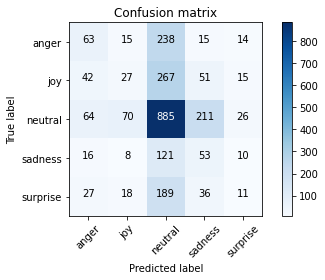

In [103]:
# cm_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,label2int)

In [104]:
print(classification_report(y_true, y_pred, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.29717   0.18261   0.22621       345
         joy    0.19565   0.06716   0.10000       402
     neutral    0.52059   0.70462   0.59878      1256
     sadness    0.14481   0.25481   0.18467       208
    surprise    0.14474   0.03915   0.06162       281

    accuracy                        0.41693      2492
   macro avg    0.26059   0.24967   0.23426      2492
weighted avg    0.36349   0.41693   0.37161      2492



In [105]:
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
# f1_none = f1_score(y_true, y_pred, zero_division=1)

print('F1-score SER model: ',f1_micro)

F1-score SER model:  0.41693418940609955


In [106]:
#save the final SER model
# model.save('drive/MyDrive/Thesis_code/model/BiLSTM_SER-5emo-bal')

In [107]:
#save numpy code
# np.save('./drive/MyDrive/Thesis_code/features/X_train_5emo_bal.npy',X_mfcc)
# np.save('./drive/MyDrive/Thesis_code/features/X_test_5emo_bal.npy',X_test_mfcc)

##Hyperparameter Tuning

In [ ]:
# print('Best Score: %s' % grid_result.best_score_)
# print('Best Hyperparameters: %s' % grid_result.best_params_)

In [ ]:
# grid_result = grid.fit(X, y)

In [ ]:
# grid = RandomizedSearchCV(estimator=model_2, cv=KFold(3), param_distributions=param_grid, 
#                           verbose=20,  n_iter=10, n_jobs=1, scoring='accuracy')

In [ ]:
# learning algorithm parameters
# lr=[1e-2, 1e-3, 1e-4]
# decay=[1e-6,1e-9,0]

# # activation
# activation=['relu', 'sigmoid','tanh']

# # numbers of layers
# nl1 = [0,1,2,3]
# nl2 = [0,1,2,3]
# nl3 = [0,1,2,3]

# # neurons in each layer
# nn1=[300,700,1400, 2100,]
# nn2=[100,400,800]
# nn3=[50,150,300]

# # dropout and regularisation
# dropout = [0, 0.1, 0.2, 0.3,0.4]
# l1 = [0, 0.01, 0.003, 0.001,0.0001]
# l2 = [0, 0.01, 0.003, 0.001,0.0001]

# # dictionary summary
# param_grid = dict(
#                     act=activation, lr=lr, decay=decay, dropout=dropout,
#                  )

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from keras.wrappers.scikit_learn import KerasClassifier

# model_2 = KerasClassifier(build_fn=model, epochs=5, batch_size=32, verbose=1)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)
# # define search
# search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# # execute search
# result = search.fit(X, y)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)